# 使用numpy手写实现CNN

In [1]:
import numpy as np
np.random.seed(10001)

class Tensor:
    def __init__(self, shape):
        self.data = np.zeros(shape=shape, dtype=np.float32) # 存放数据
        self.grad = np.zeros(shape=shape, dtype=np.float32) # 存放梯度

    def clear_grad(self):
        self.grad = np.zeros_like(self.grad)

    def __str__(self):
        return "Tensor shape: {}, data: {}".format(self.data.shape, self.data)


# Tensor的初始化类，目前仅提供Normal初始化和Constant初始化
class Initializer:
    """
    基类
    """
    def __init__(self, shape=None, name='initializer'):
        self.shape = shape
        self.name = name

    def __call__(self, *args, **kwargs):
        raise NotImplementedError

    def __str__(self):
        return self.name


class Constant(Initializer):
    def __init__(self, value=0., name='constant initializer', *args, **kwargs):
        super().__init__(name=name, *args, **kwargs)
        self.value = value

    def __call__(self, shape=None, *args, **kwargs):
        if shape:
            self.shape = shape
        assert shape is not None, "the shape of initializer must not be None."
        return self.value + np.zeros(shape=self.shape)


class Normal(Initializer):
    def __init__(self, mean=0., std=0.01, name='normal initializer', *args, **kwargs):
        super().__init__(name=name, *args, **kwargs)
        self.mean = mean
        self.std = std

    def __call__(self, shape=None, *args, **kwargs):
        if shape:
            self.shape = shape
        assert shape is not None, "the shape of initializer must not be None."
        return np.random.normal(self.mean, self.std, size=self.shape)

In [2]:
class Layer:
    def __init__(self, name='layer', *args, **kwargs):
        self.name = name

    def forward(self, *args, **kwargs):
        raise NotImplementedError

    def backward(self):
        raise NotImplementedError

    def parameters(self):
        return []

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    def __str__(self):
        return self.name


class Linear(Layer):
    """
    input X, shape: [N, C]
    output Y, shape: [N, O]
    weight W, shape: [C, O]
    bias b, shape: [1, O]
    grad dY, shape: [N, O]
    forward formula:
        Y = X @ W + b   # @表示矩阵乘法
    backward formula:
        dW = X.T @ dY
        db = sum(dY, axis=0)
        dX = dY @ W.T
    """
    def __init__(
        self,
        in_features,
        out_features,
        name='linear',
        weight_attr=Normal(),
        bias_attr=Constant(),
        *args,
        **kwargs
        ):
        super().__init__(name=name, *args, **kwargs)
        self.weights = Tensor((in_features, out_features))
        self.weights.data = weight_attr(self.weights.data.shape)
        self.bias = Tensor((1, out_features))
        self.bias.data = bias_attr(self.bias.data.shape)
        self.input = None

    def forward(self, x):
        self.input = x
        output = np.dot(x, self.weights.data) + self.bias.data
        return output

    def backward(self, gradient):
        self.weights.grad += np.dot(self.input.T, gradient)  # dy / dw
        self.bias.grad += np.sum(gradient, axis=0, keepdims=True)  # dy / db 
        input_grad = np.dot(gradient, self.weights.data.T)  # dy / dx
        return input_grad

    def parameters(self):
        return [self.weights, self.bias]

    def __str__(self):
        string = "linear layer, weight shape: {}, bias shape: {}".format(self.weights.data.shape, self.bias.data.shape)
        return string


class ReLU(Layer):
    """
    forward formula:
        relu = x if x >= 0
             = 0 if x < 0
    backwawrd formula:
        grad = gradient * (x > 0)
    """
    def __init__(self, name='relu', *args, **kwargs):
        super().__init__(name=name, *args, **kwargs)
        self.activated = None

    def forward(self, x):
        x[x < 0] = 0
        self.activated = x
        return self.activated

    def backward(self, gradient):
        return gradient * (self.activated > 0)

In [3]:
class Sequential:
    def __init__(self, *args, **kwargs):
        self.graphs = []
        self._parameters = []
        for arg_layer in args:
            if isinstance(arg_layer, Layer):
                self.graphs.append(arg_layer)
                self._parameters += arg_layer.parameters()

    def add(self, layer):
        assert isinstance(layer, Layer), "The type of added layer must be Layer, but got {}.".format(type(layer))
        self.graphs.append(layer)
        self._parameters += layer.parameters()

    def forward(self, x):
        for graph in self.graphs:
            x = graph(x)
        return x

    def backward(self, grad):
        # grad backward in inverse order of graph
        for graph in self.graphs[::-1]:
            grad = graph.backward(grad)

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    def __str__(self):
        string = 'Sequential:\n'
        for graph in self.graphs:
            string += graph.__str__() + '\n'
        return string

    def parameters(self):
        return self._parameters


In [4]:
class Optimizer:
    """
    optimizer base class.
    Args:
        parameters (Tensor): parameters to be optimized.
        learning_rate (float): learning rate. Default: 0.001.
        weight_decay (float): The decay weight of parameters. Defaylt: 0.0.
        decay_type (str): The type of regularizer. Default: l2.
    """
    def __init__(self, parameters, learning_rate=0.001, weight_decay=0.0, decay_type='l2'):
        assert decay_type in ['l1', 'l2'], "only support decay_type 'l1' and 'l2', but got {}.".format(decay_type)
        self.parameters = parameters
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.decay_type = decay_type

    def step(self):
        raise NotImplementedError

    def clear_grad(self):
        for p in self.parameters:
            p.clear_grad()

    def get_decay(self, g):
        if self.decay_type == 'l1':
            return self.weight_decay
        elif self.decay_type == 'l2':
            return self.weight_decay * g


class SGD(Optimizer):
    def __init__(self, momentum=0.9, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.momentum = momentum
        self.velocity = []
        for p in self.parameters:
            self.velocity.append(np.zeros_like(p.grad))

    def step(self):
        for p, v in zip(self.parameters, self.velocity):
            decay = self.get_decay(p.grad)
            v = self.momentum * v + p.grad + decay # 动量计算
            p.data = p.data - self.learning_rate * v

In [5]:
class SoftmaxWithLogits(Layer):
    """
    Softmax with logits error:
        loss[j] = -input[class] + log(sum(exp(input)))
    """
    def __init__(self, reduction='mean', name='softamxwithlogits', *args, **kwargs):
        super().__init__(name=name, *args, **kwargs)
        assert reduction in ['mean', 'none', 'sum'], "reduction only support 'mean', 'none' and 'sum', but got {}.".format(reduction)
        self.reduction = reduction
        self.logits = None
        self.target = None

    def forward(self, logits, target):
        """
        :param y (np.ndarray): predicted logits, shape [N, C]
        :param target (np.ndarray): target logits, shape [N, 1]
        :return: loss
        """
        assert logits.shape[0] == target.shape[0], "The first fimension of logits and target is not same, logits shape {} cann't match target shape {}.".format(logits.shape, target.shape)
        self.logits = logits
        self.target = target
        loss = []
        for i in range(logits.shape[0]):
            loss_i = -logits[i, target.squeeze(-1)[i]] + np.log(np.sum(np.exp(logits[i])))
            loss.append(loss_i)
        loss = np.array(loss).reshape(target.shape)
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

    def backward(self):
        soft_denominator = np.sum(np.exp(self.logits), axis=1, keepdims=True)  # [N, 1]
        eq_grad = np.zeros_like(self.logits)
        for i in range(self.logits.shape[0]):
            eq_grad[i, self.target.squeeze(-1)[i]] = -1
        gradient = np.exp(self.logits) / soft_denominator + eq_grad
        return gradient

# loss_fn = SoftmaxWithLogits()
# logits = np.array([[1., 2., 3.]])
# target = np.array([[1]])
# print(-2 + np.log(np.exp(1)+np.exp(2)+np.exp(3)))
# print(logits.shape, target.shape)
# print(loss_fn(logits, target))
# print(loss_fn.backward(), np.exp(2) / (np.exp(1)+np.exp(2)+np.exp(3)))

In [6]:
class Dataset:
    def __init__(self, *args, **kwargs):
        pass

    def __getitem__(self, idx):
        raise NotImplementedError("'{}' not implement in class {}"
                                  .format('__getitem__', self.__class__.__name__))

    def __len__(self):
        raise NotImplementedError("'{}' not implement in class {}"
                                  .format('__len__', self.__class__.__name__))


# 根据dataset和一些设置，生成每个batch在dataset中的索引
class BatchSampler:
    def __init__(self, dataset=None, shuffle=False, batch_size=1, drop_last=False):
        self.batch_size = batch_size
        self.drop_last = drop_last
        self.shuffle = shuffle

        self.num_data = len(dataset)
        if self.drop_last or (self.num_data % batch_size == 0):
            self.num_samples = self.num_data // batch_size
        else:
            self.num_samples = self.num_data // batch_size + 1
        indices = np.arange(self.num_data)
        if shuffle:
            np.random.shuffle(indices)
        if drop_last:
            indices = indices[:self.num_samples * batch_size]
        self.indices = indices

    def __len__(self):
        return self.num_samples

    def __iter__(self):
        batch_indices = []
        for i in range(self.num_samples):
            if (i + 1) * self.batch_size <= self.num_data:
                for idx in range(i * self.batch_size, (i + 1) * self.batch_size):
                    batch_indices.append(self.indices[idx])
                yield batch_indices
                batch_indices = []
            else:
                for idx in range(i * self.batch_size, self.num_data):
                    batch_indices.append(self.indices[idx])
        if not self.drop_last and len(batch_indices) > 0:
            yield batch_indices


# 根据sampler生成的索引，从dataset中取数据，并组合成一个batch
class DataLoader:
    def __init__(self, dataset, sampler=BatchSampler, shuffle=False, batch_size=1, drop_last=False):
        self.dataset = dataset
        self.batch_sampler = sampler
        self.sampler = self.batch_sampler(dataset, shuffle, batch_size, drop_last)
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.batch_size = batch_size

    def __len__(self):
        return len(self.sampler)

    def __call__(self):
        self.__iter__()

    def __iter__(self):
        for sample_indices in self.sampler:
            data_list = []
            label_list = []
            for indice in sample_indices:
                data, label = self.dataset[indice]
                data_list.append(data)
                label_list.append(label)
            yield np.stack(data_list, axis=0), np.stack(label_list, axis=0)
        self.sampler = self.batch_sampler(self.dataset, self.shuffle, self.batch_size, self.drop_last)

In [7]:
class AverageMeter:
    def __init__(self):
        self.val = 0.
        self.count = 0

    def update(self, value, n=1):
        self.val += value
        self.count += n

    def __call__(self):
        return self.val / self.count

    def reset(self):
        self.val = 0.
        self.count = 0

    def __str__(self):
        return str(self.__call__())

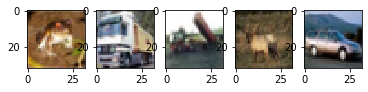

In [8]:
%matplotlib inline
import pickle
import matplotlib.pyplot as plt

# 读取cifar数据
def read_cifar(data_path):
    with open(data_path, 'rb') as f:
        data_dict = pickle.load(f, encoding='latin1')
        X = data_dict['data']
        Y = data_dict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y).reshape((10000, 1))
    return X, Y


# 仅训练10000张图片
data_path = "C:/Users/zhangxiaomi/Desktop/cifar-10-batches-py/data_batch_1"
X, Y = read_cifar(data_path)

show_number = 5
# 显示示例图片，查看数据
for i in range(show_number):
    img = X[i]
    plt.subplot(1, show_number, i + 1)
    plt.imshow(img.astype('uint8'))

In [25]:
class CifarDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx] / 255.0, self.Y[idx] # 图像值缩放到[0, 1]

# 设置超参数
train_number = 8000  # 训练集大小（共10000）
epoches = 100   # epoch
batch_size = 4  # batch_size
learning_rate = 0.009  # 学习率
num_classes = 10

In [26]:
# 划分数据集，训练集和验证集
train_X, train_Y = X[:train_number], Y[:train_number]
val_X, val_Y = X[train_number:], Y[train_number:]

# 构建dataloader
train_dataset = CifarDataset(train_X, train_Y)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

val_dataset = CifarDataset(val_X, val_Y)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, drop_last=False)

# 自己实现的模型组网
model = Sequential(
    Linear(3 * 32 * 32, 64, name='linear1'),
    ReLU(name='relu1'),
    Linear(64, 128, name='linear2'),
    ReLU(name='relu1'),
    Linear(128, 64, name='linear3'),
    ReLU(name='relu1'),
    Linear(64, num_classes, name='linear4'),
)
opt = SGD(parameters=model.parameters(), learning_rate=learning_rate, weight_decay=0.0, decay_type='l2')
loss_fn = SoftmaxWithLogits()

# 一个简单的验证函数，计算模型预测的准确率
def eval(model, val_dataloader):
    predict_labels = []
    labels = []
    for x, y in val_dataloader:
        x = x.reshape((1, -1))
        logits = model(x)
        pred = np.argmax(logits, axis=1)
        predict_labels.append(pred)
        labels.append(y.squeeze(1))
    pred = np.array(predict_labels)
    labels = np.array(labels)
    acc = np.sum(pred == labels) / len(labels)
    print("val dataset accuracy:", acc)
    return acc

# 开始训练
lddl_acc = []   
loss_avg = AverageMeter()
for epoch in range(1, epoches + 1):
    acc = eval(model, val_dataloader=val_dataloader)  # 先计算一下在验证集上的模型准确率
    lddl_acc.append(acc)  
    for idx, (x, y) in enumerate(train_dataloader):
        x = x.reshape((batch_size, -1))  # 因为用的全连接层实现分类，这里需要先reshape，修改数据维度为[batch_size, channels * H * W]
        logits = model(x)
        loss = loss_fn(logits, y)
        loss_avg.update(loss)

        grad = loss_fn.backward()
        model.backward(grad)

        opt.step()
        opt.clear_grad()
    print("epoch: {}. loss: {}".format(epoch, loss_avg))

val dataset accuracy: 0.095
epoch: 1. loss: 2.3049159276355193
val dataset accuracy: 0.099
epoch: 2. loss: 2.3046259197867514
val dataset accuracy: 0.0965
epoch: 3. loss: 2.2766451270046106
val dataset accuracy: 0.17
epoch: 4. loss: 2.2312908862174865
val dataset accuracy: 0.1775
epoch: 5. loss: 2.200715052275066
val dataset accuracy: 0.197
epoch: 6. loss: 2.1697813990354193
val dataset accuracy: 0.225
epoch: 7. loss: 2.141608951407009
val dataset accuracy: 0.256
epoch: 8. loss: 2.115382574276673
val dataset accuracy: 0.2715
epoch: 9. loss: 2.0898667136625027
val dataset accuracy: 0.271
epoch: 10. loss: 2.066488080651017
val dataset accuracy: 0.328
epoch: 11. loss: 2.0444568033479777
val dataset accuracy: 0.3265
epoch: 12. loss: 2.023447249358284
val dataset accuracy: 0.323
epoch: 13. loss: 2.0040382719945153
val dataset accuracy: 0.3405
epoch: 14. loss: 1.986298511678439
val dataset accuracy: 0.3345
epoch: 15. loss: 1.9692917647006496
val dataset accuracy: 0.338
epoch: 16. loss: 1.953